In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import optuna
import os as os
import matplotlib.pyplot as plt
import seaborn as sns

Load the Data Generic Function

In [3]:
# Load the data
def load_data(file_path):
    return pd.read_csv(file_path)

Preprocess The Data

In [4]:
# Preprocess the data
def preprocess_numerical_data(X_train, X_test, numerical_columns):
    """Standardize numerical features."""
    scaler = StandardScaler()
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
    return X_train, X_test

Split Data

In [5]:
# Split the data
def split_data(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

Create the objective function for Optuna

In [6]:
# Define the objective function for Optuna
def objective(trial, X_train, X_test, y_train, y_test):
    # Define the model
    model_name = trial.suggest_categorical('model', ['rf', 'lr', 'svm'])
    
    if model_name == 'rf':
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 100),
            max_depth=trial.suggest_int('max_depth', 2, 32, log=True)
        )
    elif model_name == 'lr':
        model = LogisticRegression(
            C=trial.suggest_loguniform('C', 1e-5, 1e5)
        )
    else:  # SVM
        model = SVC(
            C=trial.suggest_loguniform('C', 1e-5, 1e5),
            kernel=trial.suggest_categorical('kernel', ['rbf', 'linear'])
        )
    
    # Create a pipeline with preprocessing and model
    pipeline = Pipeline([
        ('classifier', model)
    ])
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = pipeline.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    return accuracy

Feature Importance

In [7]:
# Function to plot feature importance
def plot_feature_importance(model, feature_names):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title("Feature Importance")
        plt.bar(range(len(importances)), importances[indices], align="center")
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("The model does not have feature importances attribute.")


The Main Function

Path: C:/Users/gurme/Desktop//ML Datasets

[I 2024-07-30 23:16:51,394] A new study created in memory with name: no-name-32f8d240-780d-404e-a549-9ae563182fdb


[I 2024-07-30 23:16:51,606] Trial 0 finished with value: 0.9466666666666667 and parameters: {'model': 'rf', 'n_estimators': 45, 'max_depth': 5}. Best is trial 0 with value: 0.9466666666666667.
C:\Users\gurme\AppData\Local\Temp\ipykernel_13660\3325772740.py:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest_loguniform('C', 1e-5, 1e5),
[I 2024-07-30 23:16:51,746] Trial 1 finished with value: 0.8566666666666667 and parameters: {'model': 'svm', 'C': 475.175363929145, 'kernel': 'rbf'}. Best is trial 0 with value: 0.9466666666666667.
C:\Users\gurme\AppData\Local\Temp\ipykernel_13660\3325772740.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C=trial.suggest

Best accuracy: 0.96
Best hyperparameters: {'model': 'rf', 'n_estimators': 99, 'max_depth': 32}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       172
           1       0.99      0.91      0.95       128

    accuracy                           0.96       300
   macro avg       0.96      0.95      0.96       300
weighted avg       0.96      0.96      0.96       300



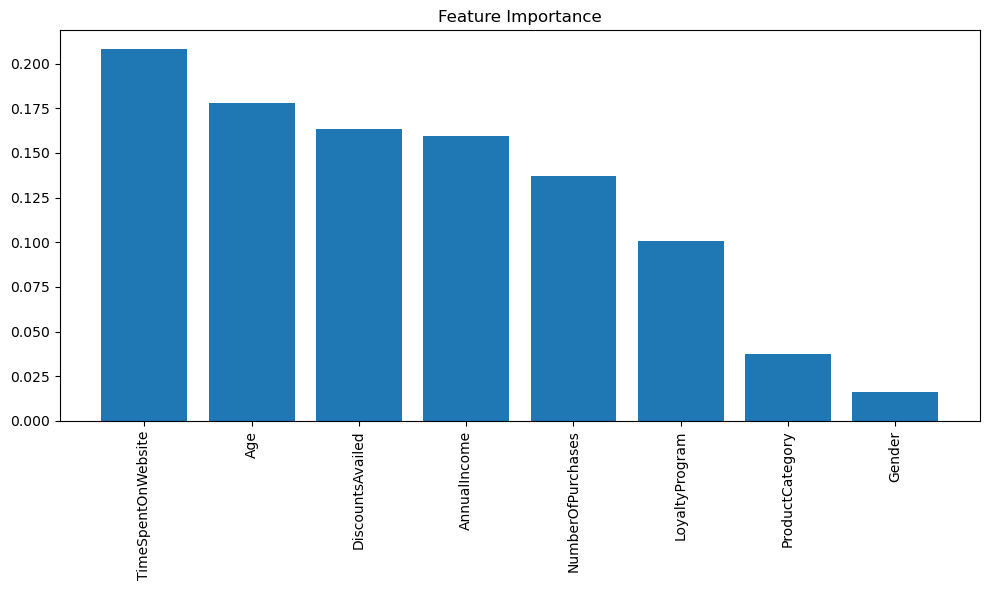

In [8]:
# Main function
def main():
    # Change current working directory
    os.chdir("C:/Users/gurme/Desktop/ML Datasets")
    # Load data
    df = load_data('customer_purchase_data.csv')
    
    # Define column types
    numerical_columns = ['TimeSpentOnWebsite', 'AnnualIncome']  # replace with your numerical columns
    target_column = 'PurchaseStatus'  # replace with your target column name
    
    # Separate features and target
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Preprocess numerical data
    X_train, X_test = preprocess_numerical_data(X_train, X_test, numerical_columns)
    
    # Perform Bayesian optimization
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=100)
    
    # Get the best model
    best_trial = study.best_trial
    
    print(f"Best accuracy: {best_trial.value}")
    print("Best hyperparameters:", best_trial.params)
    
    # Train the best model
    best_model = None
    if best_trial.params['model'] == 'rf':
        best_model = RandomForestClassifier(n_estimators=best_trial.params['n_estimators'], max_depth=best_trial.params['max_depth'])
    elif best_trial.params['model'] == 'lr':
        best_model = LogisticRegression(C=best_trial.params['C'])
    else:
        best_model = SVC(C=best_trial.params['C'], kernel=best_trial.params['kernel'])
    
    best_pipeline = Pipeline([
        ('classifier', best_model)
    ])
    
    best_pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred = best_pipeline.predict(X_test)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot feature importance
    plot_feature_importance(best_model, X.columns)


if __name__ == "__main__":
    main()